## 导入库和数据

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("example_data_transposed.csv",parse_dates=["trade_date"],index_col=[0])
df.head()

,Row1,Row2,Row3,Row4,Row5,Row6,Row7,Row8,Row9
trade_date,,,,,,,,,
2014-06-19,0.009400,-0.241265,-0.062255,0.396046,-0.200110,0.892711,7.741112,7.042818,15.161542
2014-06-20,0.021499,-0.235724,-0.091477,0.399708,-0.203983,0.895268,7.745161,7.045542,15.164007
2014-06-23,-0.003928,-0.211690,-0.083402,0.392153,-0.203865,0.896612,7.749445,7.048199,15.166476
2014-06-24,-0.004123,-0.254588,-0.035452,0.373585,-0.199849,0.896718,7.753970,7.050790,15.168949
2014-06-25,-0.036716,-0.274480,0.029313,0.345070,-0.192232,0.895568,7.758738,7.053315,15.171426


In [3]:
df = df["Row9"]
df = pd.DataFrame(df)

In [4]:
test_split=round(len(df)*0.20)
df.shape

(2381, 1)

In [5]:
df_for_training=df[:-1041]
df_for_testing=df[-1041:]
print(df_for_training.shape)
print(df_for_testing.shape)

(1340, 1)
(1041, 1)


In [6]:
df=df.astype(float)

## 进行minmax标准化

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.00000000e+00],
       [4.45162492e-04],
       [8.91070870e-04],
       ...,
       [9.98297341e-01],
       [9.99148739e-01],
       [1.00000000e+00]])

In [8]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
 
 
    trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)
trainX,trainY=createXY(df_for_training_scaled,30)

In [9]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

 
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)


trainX Shape--  (1310, 30, 1)
trainY Shape--  (1310,)
testX Shape--  (1011, 30, 1)
testY Shape--  (1011,)


## 定义LSTM模型+优化参数算法

In [10]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1)
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)
grid_search = grid_search.fit(trainX,trainY,validation_data=(testX,testY))

<ipython-input-10-02a27f7b2eb5>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1)


Epoch 1/8
41/41 [==============================] - 4s 37ms/step - loss: 0.1022 - val_loss: 0.0345
Epoch 2/8
41/41 [==============================] - 1s 18ms/step - loss: 0.0065 - val_loss: 0.0466
Epoch 3/8
41/41 [==============================] - 1s 18ms/step - loss: 0.0045 - val_loss: 0.0073
Epoch 4/8
41/41 [==============================] - 1s 19ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 5/8
41/41 [==============================] - 1s 18ms/step - loss: 0.0049 - val_loss: 7.4506e-04
Epoch 6/8
41/41 [==============================] - 1s 19ms/step - loss: 0.0045 - val_loss: 4.4187e-04
Epoch 7/8
41/41 [==============================] - 1s 20ms/step - loss: 0.0038 - val_loss: 4.7447e-04
Epoch 8/8
41/41 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 1/8
41/41 [==============================] - 4s 36ms/step - loss: 0.0078 - val_loss: 0.0330
Epoch 2/8
41/41 [==============================] - 1s 21ms/step - loss: 6.5240e-04 - val_loss: 0.0183
Epoch 3/8
41/41 [=======

33/33 [==============================] - 1s 23ms/step - loss: 0.0040 - val_loss: 0.0079
Epoch 6/8
33/33 [==============================] - 1s 25ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 7/8
33/33 [==============================] - 1s 23ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 8/8
33/33 [==============================] - 0s 6ms/step - loss: 7.3410e-04
Epoch 1/8
33/33 [==============================] - 4s 42ms/step - loss: 0.0062 - val_loss: 0.0164
Epoch 2/8
33/33 [==============================] - 1s 25ms/step - loss: 7.6614e-04 - val_loss: 0.0028
Epoch 3/8
33/33 [==============================] - 1s 26ms/step - loss: 6.0171e-04 - val_loss: 0.0030
Epoch 4/8
33/33 [==============================] - 1s 22ms/step - loss: 4.0987e-04 - val_loss: 0.0044
Epoch 5/8
33/33 [==============================] - 1s 21ms/step - loss: 4.3273e-04 - val_loss: 0.0114
Epoch 6/8
33/33 [==============================] - 1s 21ms/step - loss: 4.4723e-04 - val_loss: 0.0100
Epoch 7/8
33/33 [=========

Epoch 10/10
82/82 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0042


输出LSTM模型的最优参数，重新定义模型

batch_size: 批量大小，表示在训练过程中每次输入给模型的样本数量。训练时数据通常会被分成多个批次进行处理，每个批次包含指定数量的样本。在这里，batch_size被设置为20，意味着每次训练时，模型会接收20个样本，并使用这20个样本的平均梯度来更新模型的权重。

epochs: 迭代次数，表示在整个训练数据上重复训练的次数。在每个迭代期间，模型会遍历所有的训练样本，通过反向传播和优化算法来更新模型的权重。在这里，epochs被设置为10，意味着整个训练数据会被遍历10次。

optimizer: 优化器，用于更新模型的权重以最小化损失函数。在这里，使用了Adam优化器，它是一种常用的自适应学习率优化算法，可以帮助加速神经网络的训练过程。

In [11]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [12]:
my_model=grid_search.best_estimator_.model

In [13]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape) #重新进行预测

32/32 [==============================] - 1s 5ms/step
prediction
 [[1.0418345]
 [1.0426185]
 [1.0434021]
 ...
 [1.5622033]
 [1.562431 ]
 [1.562658 ]]

Prediction Shape- (1011, 1)


在将时间序列数据转换为多时间步的输入序列时，进行数据扩增（data augmentation）等情况。

在LSTM模型的预测中使用np.repeat函数通常是为了将预测结果进行重复，从而使其与输入数据的形状保持一致，以便进行比较或进一步处理。

当使用LSTM进行时间序列预测时，通常会将输入数据组织成多个时间步的序列，例如每个时间步包含过去几天的数据。LSTM模型在进行预测时，会生成未来某个时间步的预测值，通常是单个时间步的预测。

然而，为了将预测结果与输入数据进行对应，有时需要将预测值复制多次，使其与输入数据的时间步数相同。这就是使用np.repeat函数的目的。

让我们假设有一个LSTM模型进行销售量预测，我们使用过去5天的销售量作为输入来预测未来1天的销售量。LSTM模型会生成一个预测值，但是我们希望将这个预测值与过去5天的销售量进行对应，这样更方便进行比较和可视化。

例如，假设LSTM模型预测的销售量为prediction = [100]，我们使用np.repeat(prediction, 5, axis=-1)，将其重复5次，得到prediction_copies_array = [100, 100, 100, 100, 100]，然后将prediction_copies_array与过去5天的销售量进行对应。这样，我们就可以将预测值与输入数据形状一致，方便后续的处理和分析。

In [14]:
prediction_copies_array = np.repeat(prediction,30, axis=-1) 

In [15]:
prediction_copies_array.shape

(1011, 30)

scaler.inverse_transform: 这是MinMaxScaler对象的逆转换方法，用于将归一化后的数据还原回原始数据范围。

In [16]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),30)))[:,0]

In [17]:
original_copies_array = np.repeat(testY,30, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),30)))[:,0]

In [18]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [20.930216 20.934555 20.938894 ... 23.811514 23.812777 23.814034]

Original Values--  [20.84429222 20.84897917 20.85366523 ... 24.49422085 24.49615282
 24.49808021]


## 做出预测值和真实值随着时间对比的图像

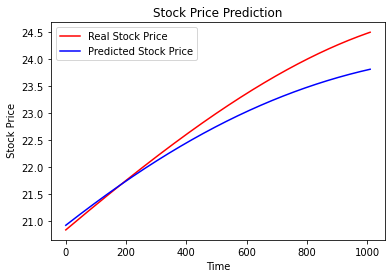

In [19]:
plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

## RMSE、MAE法检测

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 示例真实值和预测值
y_true = original
y_pred = pred

# 计算均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)

RMSE: 0.3576392266459654
MAE: 0.28333599963734857


## 进行外推预测

In [21]:
from keras.models import load_model

# 假设模型用过去30天的价格预测未来1天的价格
# 这里用示例数据代替
history_sales = testX[-1:]  # 过去30天的价格


# 使用模型进行外推预测
predicted_sales = my_model.predict(history_sales)

print("外推预测的价格：", predicted_sales)

1/1 [==============================] - 0s 13ms/step
外推预测的价格： [[1.562658]]


In [22]:
prediction_copies_array = np.repeat(predicted_sales,30, axis=-1) 

In [23]:
pred=scaler.inverse_transform(predicted_sales)

In [24]:
pred

array([[23.814034]], dtype=float32)